# Using ReNA to find supervoxels 

The aims of the notebook is to provide an illustration of how to use ReNA 
to build superpixels. This corresponds to clustering voxels. 

Here we use the Haxby dataset, which can be fetched via nilearn. 

## Loading the data

In [1]:
from nilearn import datasets
dataset = datasets.fetch_haxby(subjects=1)

import numpy as np
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_strategy='epi', smoothing_fwhm=6, memory='cache')

X_masked = masker.fit_transform(dataset.func[0])
X_train = X_masked[:100, :]

X_data = masker.inverse_transform(X_train).get_data()

n_x, n_y, n_z, n_samples = X_data.shape
mask = masker.mask_img_.get_data()

print('number of samples: %i, \nDimensions n_x: %i, n_y: %i, n_z: %i' % (n_samples, n_x, n_y, n_z))

number of samples: 100, 
Dimensions n_x: 40, n_y: 64, n_z: 64


## Get the connectivity (spatial structure)

In [2]:
from sklearn.feature_extraction.image import grid_to_graph
from rena import weighted_connectivity_graph

connectivity_ward = grid_to_graph(n_x=n_x, n_y=n_y, n_z=n_z, mask=mask)

connectivity_rena = weighted_connectivity_graph(X_data,
                                                n_features=X_masked.shape[1],
                                                mask=mask)

rena.py:57: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 646144 but corresponding boolean dimension is 482304
  weights = weights[edges_mask]


In [3]:
import time
from sklearn.cluster import AgglomerativeClustering
from rena import recursive_nearest_agglomeration

n_clusters = 2000

ward = AgglomerativeClustering(n_clusters=n_clusters,
                               connectivity=connectivity_ward, 
                               linkage='ward')

ti_ward = time.clock()
ward.fit(X_masked.T)
to_ward = time.clock() - ti_ward
labels_ward = ward.labels_

ti_rena = time.clock()
labels_rena = recursive_nearest_agglomeration(X_masked, connectivity_rena,
                                              n_clusters=n_clusters)
to_rena = time.clock() - ti_rena

print('Time Ward: %0.3f, Time ReNA: %0.3f' % (to_ward, to_rena))

Time Ward: 6.699, Time ReNA: 1.174


## Custering

In [4]:
from rena import reduce_data, approximate_data

X_red_rena = reduce_data(X_masked, labels_rena)
X_red_ward = reduce_data(X_masked, labels_ward)

X_approx_rena = approximate_data(X_red_rena, labels_rena)
X_approx_ward = approximate_data(X_red_ward, labels_ward)

## Visualizing the results

In [5]:
def visualize_labels(labels, masker):
    # Shuffle the labels (for better visualization):
    permutation = np.random.permutation(labels.shape[0])
    labels = permutation[labels]
    return masker.inverse_transform(labels)


cut_coords = (-34, -16)
n_image = 0

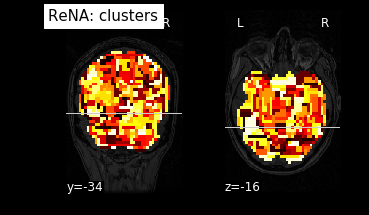

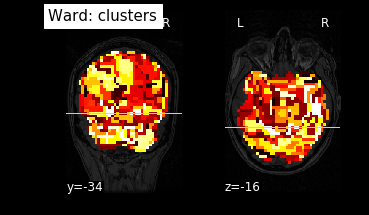

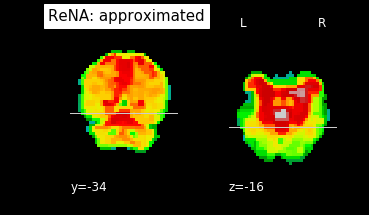

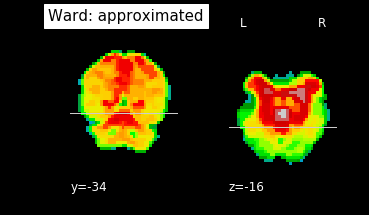

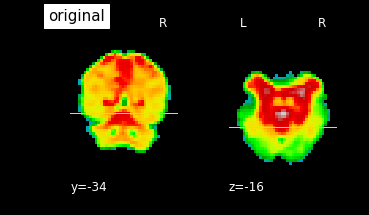

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_epi

labels_rena_img = visualize_labels(labels_rena, masker)
labels_ward_img = visualize_labels(labels_ward, masker)


clusters_rena_fig = plot_stat_map(labels_rena_img, bg_img=dataset.anat[0],
                                  title='ReNA: clusters', display_mode='yz',
                                  cut_coords=cut_coords, colorbar=False)

clusters_ward_fig = plot_stat_map(labels_ward_img, bg_img=dataset.anat[0],
                                  title='Ward: clusters', display_mode='yz',
                                  cut_coords=cut_coords, colorbar=False)

compress_rena_fig = plot_epi(masker.inverse_transform(X_approx_rena[n_image]),
                             title='ReNA: approximated', display_mode='yz',
                             cut_coords=cut_coords)
compress_ward_fig = plot_epi(masker.inverse_transform(X_approx_ward[n_image]),
                             title='Ward: approximated', display_mode='yz',
                             cut_coords=cut_coords)

original_fig = plot_epi(masker.inverse_transform(X_masked[n_image]),
                        title='original', display_mode='yz',
                        cut_coords=cut_coords)
plt.show()

In [7]:
# saving data
clusters_rena_fig.savefig('figures/clusters_rena.png')
clusters_ward_fig.savefig('figures/clusters_ward.png')
compress_rena_fig.savefig('figures/compress_rena.png')
compress_ward_fig.savefig('figures/compress_ward.png')
original_fig.savefig('figures/original.png')